# Prediction of surgery vs non-sergery using taxonomy profile

Train machine learning models on sepecies abundance to predict if the sample is from a patient tha has undergone surgery

In [3]:
%matplotlib inline
import numpy as np 
import biom
import pandas as pd 
import seaborn as sns
import qiime2 as q2
from matplotlib import pyplot as plt

def load_mf(fn, index='#SampleID'):
    _df = pd.read_csv(fn, sep='\t', dtype='str', na_values=[], keep_default_na=False)
    _df.set_index(index, inplace=True)
    return _df

In [5]:
df_species = q2.Artifact.load('data/feature-table.noblanks.even40k.qza').view(pd.DataFrame).T.copy()

df_meta = load_mf('data/11546_20190118-122918.txt', 'sample_name')
df_meta = df_meta.query('empo_1 == "Host-associated"').copy()

#create dictionary to 
dic_date=dict(zip(list(df_meta.index),list(df_meta.time_point)))
dic_surgery=dict(zip(list(df_meta.index),list(df_meta.surgery_type)))

## RandomForest classifier for 2 groups: surgery vs no surgery

### Split approach: Separates by subjects
make sure subject in training data does not overlap with subjects in test data


In [6]:
from random import sample 
#organize subjects and samples, and record their surgery status
dic_subject=dict(zip(list(df_meta.host_id),list(df_meta.surgery_type)))
dic_sample_host=dict(zip(list(df_meta.index),list(df_meta.host_id)))
subject_nonsurgery=[i for i in dic_subject.keys() if dic_subject[i]=='none']
subject_surgery=[i for i in dic_subject.keys() if i not in subject_nonsurgery]

# write a function to randomly split test and training set, so that the subjects in test and training do not overlap 
# 70% percent of the subjects are in training samples while 30% subjects are in test samples
def split_data(df_meta,df_species):
    #use randome sample to select ~70% subject from each group as training data 
    sub_train_nosurg=sample(subject_nonsurgery,int(len(subject_nonsurgery)*0.7))
    sub_train_surg=sample(subject_surgery,int(len(subject_surgery)*0.7))
    sub_train=sub_train_nosurg+sub_train_surg

    #map subjects back to samples and build the training dataset 
    sample_train=[i for i in df_species.columns if dic_sample_host[i] in sub_train]
    sample_test=[i for i in df_species.columns if i not in sample_train]
    X_train=df_species[sample_train]
    X_test=df_species[sample_test]
    
    ## create the output 
    y_train=[]
    for i in X_train.columns: 
        if dic_surgery[i]=='none': 
            y_train.append(0)
        else: 
            y_train.append(1)

    y_test=[]
    for i in X_test.columns: 
        if dic_surgery[i]=='none': 
            y_test.append(0)
        else: 
            y_test.append(1)
    return X_train, X_test,y_test,y_train

X_train, X_test,y_test,y_train=split_data(df_meta,df_species)

### Train and test the model

In [7]:
#train regressor and run it on test data 
from sklearn.ensemble import RandomForestClassifier
class_rf = RandomForestClassifier(n_jobs=4)
class_rf.fit(X_train.T, y_train)

# 10-fold cross validation on the test data 
from sklearn.model_selection import cross_val_score
scores = cross_val_score(class_rf, X_train.T, y_train, cv=10)
print('cross-validation on the training data: ')
print(scores)

# Predict on new data
y_rf = class_rf.predict(X_test.T)

# calculate the accuracy score of the classifier 
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score

print('Prediction accuracy score on the test data: ', accuracy_score(y_test, y_rf) )
average_precision=average_precision_score(y_test, y_rf) 
print('Average precision-recall score: ', average_precision)

/Users/yoshikivazquezbaeza/miniconda/envs/qiime2-2019.1/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


cross-validation on the training data: 
[0.79166667 0.91666667 0.83333333 0.875      0.81818182 0.86363636
 0.90909091 0.86363636 0.95454545 0.86363636]
Prediction accuracy score on the test data:  0.7864077669902912
Average precision-recall score:  0.6759601684820267


## Randomly split data, train and test the model for 100 times 
### Record ad calculate the average precision-recall score 
### identify the most important species that had the highest occurance

In [12]:
from sklearn.metrics import accuracy_score, roc_curve, average_precision_score, auc

#define classifier 
from sklearn.ensemble import RandomForestClassifier
class_rf = RandomForestClassifier(n_jobs=4, n_estimators=300)
y_test_all=[]
y_rf_all=[]
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
pcscore_list=[]
featuelist=[]
for i in range(100): 
    print(i)
    X_train, X_test,y_test,y_train=split_data(df_meta,df_species)
    class_rf.fit(X_train.T, y_train)
    # Predict on new data
    y_rf = class_rf.predict_proba(X_test.T)[:, 1]
    #record the y_test and y_rf for each iteration so it could be used to calculate over all precision-recall curve
    y_test_all.append(y_test)
    y_rf_all.append(y_rf)

    # calculate the accuracy score of the classifier 
    pcscore_list.append(average_precision_score(y_test, y_rf))
    ind_top30=sorted(range(len(class_rf.feature_importances_)), key=lambda i: class_rf.feature_importances_[i])[-30:]
    for i in ind_top30: 
        featuelist.append(df_species.index[i])
    probas_= class_rf.fit(X_train.T, y_train).predict_proba(X_test.T)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [13]:
# count the most important features that overlapped in 100 runs 
dic_count={}
for s in set(featuelist): 
    count=featuelist.count(s)
    dic_count[s]=count
dic_count

import operator
sorted_x = sorted(dic_count.items(), key=operator.itemgetter(1))
sorted_x

[('304.1514;0.3491', 1),
 ('391.2833;4.7678', 1),
 ('344.2795;5.6491', 1),
 ('325.1126;0.2687', 1),
 ('355.2636;4.7668', 1),
 ('252.6351;4.8545', 1),
 ('130.0858;0.2348', 1),
 ('246.1408;0.4012', 1),
 ('241.1538;0.3554', 1),
 ('589.3021;4.1474', 1),
 ('591.3178;4.1391', 1),
 ('309.1649;0.2327', 1),
 ('371.2582;4.8645', 2),
 ('373.2736;4.771', 2),
 ('358.2591;4.6851', 2),
 ('186.079;0.271', 2),
 ('143.1174;0.5794', 2),
 ('1225.8705;5.1952', 2),
 ('373.2735;5.9936', 2),
 ('834.6091;5.1946', 2),
 ('282.2788;7.9333', 2),
 ('375.289;5.9381', 2),
 ('297.2786;8.1168', 2),
 ('274.0928;0.2996', 2),
 ('429.2616;4.8697', 2),
 ('357.2786;5.5527', 3),
 ('595.3479;4.1504', 3),
 ('245.15;0.3599', 3),
 ('203.1388;0.4981', 3),
 ('122.0693;0.3061', 3),
 ('188.1753;0.2299', 3),
 ('220.1179;0.5831', 4),
 ('245.6452;5.9477', 4),
 ('239.1031;0.4107', 4),
 ('342.2643;5.2908', 4),
 ('391.2843;5.6124', 4),
 ('389.2686;4.8642', 4),
 ('203.1387;0.5148', 4),
 ('303.1699;4.7776', 4),
 ('448.3425;4.1741', 5),
 ('20

In [25]:
top = ['253.6427;5.208', '431.2768;5.1948',
       '160.1329;0.257', '373.2737;5.198', '374.2772;5.195']

_x = biom.load_table('data/boland_biom_original.biom')
for i in top:
    name = _x.metadata(i, axis='observation')['Compound_Name']
    
    if name == 'nan':
        print ('Unidentified %s:%s m/z' % tuple(i.split(';')))
    else:
        print (name)

Unidentified 253.6427:5.208 m/z
Unidentified 431.2768:5.1948 m/z
Unidentified 160.1329:0.257 m/z
Spectral Match to Cholic acid from NIST14
Unidentified 374.2772:5.195 m/z


### Precision-recall curve

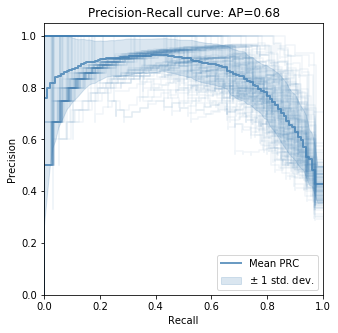

In [16]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature

mean_recall = np.linspace(0, 1, 100)
precisions = []

fig = plt.figure()
fig.set_size_inches(5, 5)

for y_test, y_prob in zip(y_test_all, y_rf_all):
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    
    precisions.append(np.interp(mean_recall, recall[::-1], precision[::-1]))
    
    plt.step(recall, precision, color='steelblue', alpha=0.08,
             where='post')
    
mean_precision = np.mean(precisions, axis=0)
    
plt.step(mean_recall, mean_precision, color='steelblue',
         label='Mean PRC',
         lw=2, alpha=.8)

std_precision = np.std(precisions, axis=0)
precision_upper = np.minimum(mean_precision + std_precision, 1)
precision_lower = np.maximum(mean_precision - std_precision, 0)

plt.fill_between(mean_recall, precision_lower, precision_upper, color='steelblue', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

plt.legend(loc="lower right")

plt.savefig('./precision-recall-curve.pdf')

### Compute ROC curve and area under the curve

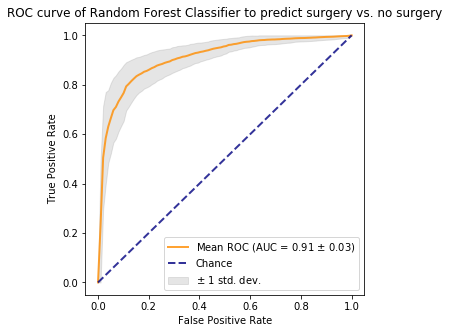

In [17]:
#plot the average AUC ROC for 100 iterations 
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
fig = plt.figure()
fig.set_size_inches(5, 5)
plt.plot(mean_fpr, mean_tpr, color='darkorange',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='navy',
         label='Chance', alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Random Forest Classifier to predict surgery vs. no surgery')
plt.legend(loc="lower right")
plt.show()
#plt.savefig('../data/Sandborn_data/figures/AUC_ROC_100_iterations_taxonomy_classification.svg')
#plt.savefig('../data/Sandborn_data/figures/AUC_ROC_100_iterations_taxonomy_classification.pdf')